In [104]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from functions import *


# Importerer filer

In [105]:
folder = 'tmdb-box-office-prediction'

trainingData = pd.read_csv(f'{folder}/train.csv')
testData = pd.read_csv(f'{folder}/test.csv')


# Visualiserer data



In [106]:
trainingData['budget'].value_counts()

budget
0           812
15000000     72
40000000     71
25000000     71
5000000      68
           ... 
747000        1
1119000       1
65000         1
1750000       1
1135654       1
Name: count, Length: 406, dtype: int64

In [107]:
trainingData['budget'] = trainingData['budget'].mask(trainingData['budget']==0).fillna(trainingData['budget'].mean())

## Deler inn i features og label

In [108]:
dropFields = ['homepage', 'original_title', 'imdb_id',
              'status', 'title', 'tagline', 'poster_path', 'overview', 'belongs_to_collection']
dropFields2 = ['Keywords', 'cast', 'crew', 'spoken_languages', 'production_countries', 'production_companies', 'genres']
trainingData = trainingData.drop(columns=dropFields + dropFields2)
#print(trainingData.size)

In [109]:
trainingData.keys()

Index(['id', 'budget', 'original_language', 'popularity', 'release_date',
       'runtime', 'revenue'],
      dtype='object')

In [110]:
#mean_value =
#trainingData[''].fillna(value=mean_value, inplace=True)

### Konverterer string til int

In [111]:
trainingData.head(10)
trainingData['original_language'].value_counts()

langauges = ['en', 'ja', 'ru', 'fr', 'no', 'ko', 'zh', 'sv', 'cn', 'es', 'id', 'hi', 'it', 'de', 'ta', 'nl', 'pt', 'fa', 'da', 'ro', 'te', 'hu', 'ml', 'pl', 'fi', 'ur', 'he', 'el', 'ar', 'nb', 'vi', 'mr', 'cs', 'sr', 'bn', 'tr']
languageId = [x for x in range(len(langauges))]

trainingData = trainingData.replace(to_replace=langauges, value=languageId)




# Renser dataene

In [112]:
'''def convertProductComp(field):
    field = field.replace("'", '"')
    data = json.loads(field)
    indexes = [item['id'] for item in data]
    print(indexes)
    return indexes'''

'def convertProductComp(field):\n    field = field.replace("\'", \'"\')\n    data = json.loads(field)\n    indexes = [item[\'id\'] for item in data]\n    print(indexes)\n    return indexes'

In [113]:
# Convert date to milliseconds
from datetime import datetime

for key in trainingData['release_date'].keys():
    try:
        date_string = str(trainingData['release_date'][key])

        date_obj = datetime.strptime(date_string, '%m/%d/%y')
        epoch = datetime(1970, 1, 1)
        time_difference = date_obj - epoch

        milliseconds = int(time_difference.total_seconds() * 1000)
        trainingData = trainingData.replace(trainingData['release_date'][key], milliseconds)
    except:
        trainingData = trainingData.drop([key])



In [114]:
# Replace all NaN budget values with mean value

meanVal = trainingData['budget'].mean()

trainingData['budget'].fillna(meanVal, inplace=True)

# Replace all NaN runtime values with mean value
meanVal = trainingData['runtime'].mean()

trainingData['runtime'].fillna(meanVal, inplace=True)


In [115]:
nan_mask = trainingData.isna()

# Filter the DataFrame to show rows with NaN values
rows_with_nan = trainingData[nan_mask.any(axis=1)]

rows_with_nan

,id,budget,original_language,popularity,release_date,runtime,revenue


# Visualisering av data

Vi sjekker hvordan budjettet til filmene fordeler seg og kan se at mange filer manger budjett (0) og vi setter derfor inn gjennomsnitt her

[]

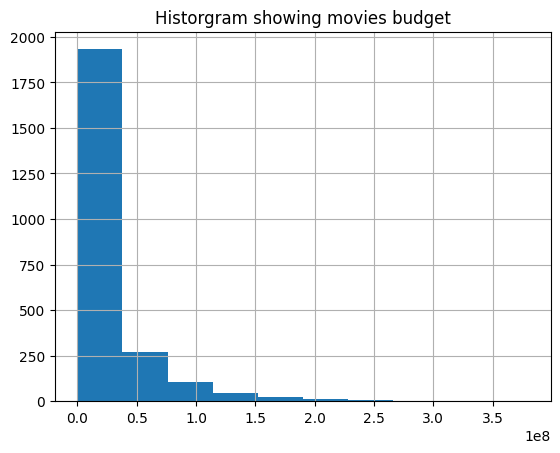

In [116]:
fig, ax = plt.subplots()
trainingData['budget'].hist(ax=ax)
ax.set_xlabel =('Budget')
ax.set_ylabel =('Frequency')
ax.set_title('Historgram showing movies budget')
plt.plot()

Vi kan se at det er en sammenheng mellom budget og revenue, hvor grønn er lavt budget og det gjennspeilter noe revenue.

### Budsjett mot revenue

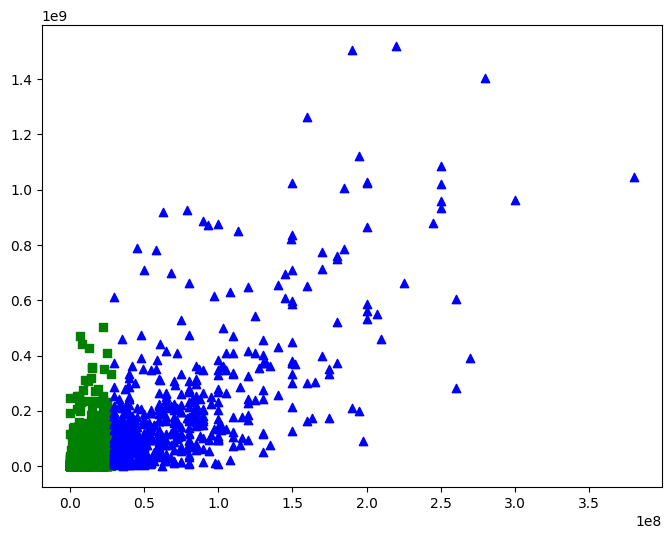

In [117]:
budget = trainingData['budget']
meanBudget = budget.mean()
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x=trainingData[budget < meanBudget]['budget'], y=trainingData[budget < meanBudget]['revenue'], marker='s', color='green')
ax.scatter(x=trainingData[budget >= meanBudget]['budget'], y=trainingData[budget >= meanBudget]['revenue'], marker='^', color='blue')
plt.show()

Se om det er en sammenheng mellom språk og revenue

In [118]:
lang = trainingData['original_language']

lang.value_counts()

original_language
0     2056
3       67
2       36
1       35
11      33
9       33
12      22
8       16
6       15
5       14
13      14
14      13
7        7
15       6
17       4
16       4
18       4
19       3
35       2
26       1
34       1
21       1
30       1
29       1
4        1
27       1
25       1
32       1
24       1
31       1
20       1
33       1
10       1
Name: count, dtype: int64

In [98]:

#plt.show()

### Orginalt språk mot revenue

Skilt ut de 4 språkene som forekommer flest ganger og en for alle andre språk. Vi kan se at engelsk skiller seg ut, men ellers er det noe uklart

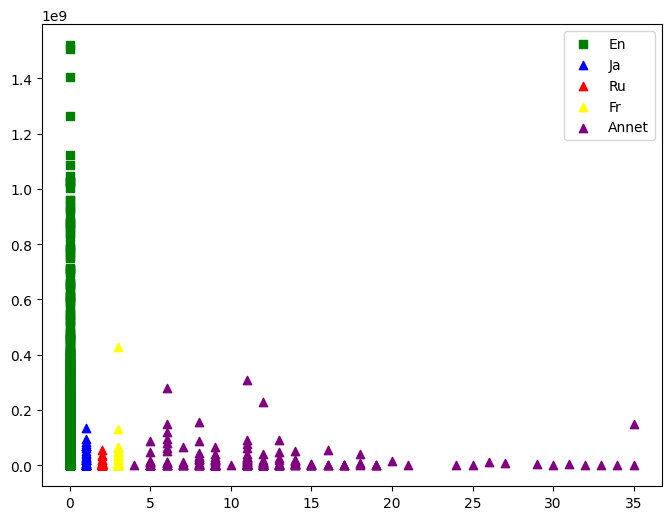

In [122]:
lang = trainingData['original_language']
meanBudget = budget.mean()
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(x=trainingData[lang == 0]['original_language'], y=trainingData[lang == 0]['revenue'], marker='s', color='green', label=langauges[0].capitalize())
ax.scatter(x=trainingData[lang == 1]['original_language'], y=trainingData[lang == 1]['revenue'], marker='^', color='blue', label=langauges[1].capitalize())
ax.scatter(x=trainingData[lang == 2]['original_language'], y=trainingData[lang == 2]['revenue'], marker='^', color='red', label=langauges[2].capitalize())
ax.scatter(x=trainingData[lang == 3]['original_language'], y=trainingData[lang == 3]['revenue'], marker='^', color='yellow', label=langauges[3].capitalize())
ax.scatter(x=trainingData[lang >= 4]['original_language'], y=trainingData[lang >= 4]['revenue'], marker='^', color='purple', label='Annet')
plt.legend()
plt.show()

# ML

In [102]:
try:
    label = trainingData['revenue']
    id = trainingData['id']
except:
    pass

features = trainingData.drop(columns='revenue')

X, y = features, label

In [109]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

models = {"Linear reg":LinearRegression(),
          "Random forest":RandomForestRegressor(n_estimators=100),
          "Decition tree":DecisionTreeRegressor(),
          "Bayesian ridge": BayesianRidge()}

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


predModelsDict = {'test': {}, 'val':{}}

for key in models.keys():
    trainModel(models[key], X_train, y_train)
    predModelsDict['test'][key] = predictWithModel(models[key], X_test)
    predModelsDict['val'][key] = predictWithModel(models[key], X_val)







In [119]:
# Printing results from the models

mesureDict = {'mse': [], 'mae': [], 'r2': []}
measures = {'mse': mean_squared_error, 'mae' :mean_absolute_error, 'r2':r2_score}

for type in predModelsDict.keys():
    predType = predModelsDict[type]
    print(f'\n{"-"*10}{type.capitalize()}{"-"*10}')
    for key in predType.keys():
        data_test = determineScore(y_test, predType[key], measures)
        data_val = determineScore(y_val, predType[key], measures)
        print(f'\n{key}:')
        for key1 in data_test.keys():
            print(f"{key1.capitalize()}: {data_test[key1]}\t{data_val[key1]}")

            mesureDict[key1].append(data_test[key1])
            mesureDict[key1].sort()
            if key1.lower() == 'r2':
                mesureDict[key1].sort(reverse=True)









----------Test----------

Linear reg:
Mse: 6147219223253791.0	3.0112162729923876e+16
Mae: 42079250.512250885	96141945.90474087
R2: 0.6569589468483279	-0.3806751787986413

Random forest:
Mse: 4929686904081284.0	3.2879093135615544e+16
Mae: 38043802.41213889	95078985.18319443
R2: 0.7249024435492737	-0.5075419258624583

Decition tree:
Mse: 1.095662248400533e+16	4.261828902572143e+16
Mae: 54925293.68611111	105039030.67222223
R2: 0.38857373075609547	-0.954094574622036

Bayesian ridge:
Mse: 6869909550365422.0	3.132881594045987e+16
Mae: 42996649.46984963	96524669.72831681
R2: 0.6166297440151032	-0.43646004234560376

----------Val----------

Linear reg:
Mse: 2.9036463316627748e+16	7144908920182298.0
Mae: 98497139.97422434	46015183.989572994
R2: -0.6203585058844814	0.6723982103394524

Random forest:
Mse: 3.1169917042067468e+16	7028736350464205.0
Mae: 93893753.14347222	44752773.893138885
R2: -0.7394143238479438	0.6777248481138833

Decition tree:
Mse: 4.051983509445605e+16	1.1991189968324588e+16


In [106]:
print()
for key in mesureDict.keys():
    print(f'{key}: \t{mesureDict[key]}')


mse: 	[6623907048914402.0, 7465725108484834.0, 8021187133691922.0, 1.1062681373482244e+16]
mae: 	[41362054.469458334, 44308334.34034504, 45325544.97828892, 54682861.329166666]
r2: 	[0.7164725382631814, 0.6804396446987501, 0.6566638373187281, 0.5264767535739108]


# Deploy